#Lab08

# Transformer with PyTorch

## Sequence Modeling with nn.Transformer and TorchText
================================================================================

This sample code is from the [Official Doc of PyTorch](https://pytorch.org/tutorials/beginner/transformer_tutorial.html) for language modeling using Transformer.

In [ ]:
# The torchtext package is part of the PyTorch project, which consists of data processing utilities and popular datasets for natural language.
!pip3 install torchtext==0.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyli




In this sample code, we will learn about how to train a sequence model
that uses the
[nn.Transformer](https://pytorch.org/docs/master/nn.html?highlight=nn%20transformer#torch.nn.Transformer) module.

PyTorch 1.2 release includes a standard transformer module based on the
paper [Attention is All You
Need](https://arxiv.org/pdf/1706.03762.pdf) . The transformer model
has been proved to be superior in quality for many sequence-to-sequence
problems while being more parallelizable. The ``nn.Transformer`` module
relies entirely on an attention mechanism (another module recently
implemented as [nn.MultiheadAttention](https://pytorch.org/docs/master/nn.html?highlight=multiheadattention#torch.nn.MultiheadAttention)) to draw global dependencies
between input and output. The ``nn.Transformer`` module is now highly
modularized such that a single component (like `nn.TransformerEncoder`
in this tutorial) can be easily adapted/composed.


Recall: We just practised how to implement the attention mechanism in Lab 7


![](https://github.com/pytorch/tutorials/blob/gh-pages/_static/img/transformer_architecture.jpg?raw=1)





### Define the model
----------------




In this sample code, we train ``nn.TransformerEncoder`` model on a
language modeling task. The language modeling task is to assign a
probability for the likelihood of a given word (or a sequence of words)
to follow a sequence of words.

A sequence of tokens are passed to the embedding
layer first, followed by a positional encoding layer to account for the order
of the word (see the next paragraph for more details). The
``nn.TransformerEncoder`` consists of multiple layers of
[nn.TransformerEncoderLayer](https://pytorch.org/docs/master/nn.html?highlight=transformerencoderlayer#torch.nn.TransformerEncoderLayer) . Along with the input sequence, a square
attention mask is required because the self-attention layers in
``nn.TransformerEncoder`` are only allowed to attend the earlier positions in
the sequence. For the language modeling task, any tokens on the future
positions should be masked. To have the actual words, the output
of ``nn.TransformerEncoder`` model is sent to the final Linear
layer, which is followed by a log-Softmax function.




#### Transformer Model

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        from torch.nn import TransformerEncoder, TransformerEncoderLayer
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        #triu returns the upper triangular part of a matrix (2-D tensor) or batch of matrices (see section below)
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)
        return output

##### Masking
By passing the mask into the transformer_encoder forward() function, the attention will only be calculated on the earlier positions in the sequence.

In [ ]:
#triu returns the upper triangular part of a matrix (2-D tensor) or batch of matrices (see section below)
torch.triu(torch.ones(3, 3))

tensor([[1., 1., 1.],
        [0., 1., 1.],
        [0., 0., 1.]])

In [ ]:
# Masking
def masking():
  sz = 4
  mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
  mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))

  return mask

masking()

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

#### Positional Encoding

Transformer architecture takes base architecture of Seq2Seq model (Encoder - Decoder). However, the transformer does not use recurrent model so this means we need a module that captures sequence information of the input/output.

``PositionalEncoding`` module injects some information about the
relative or absolute position of the tokens in the sequence. The
positional encodings have the same dimension as the embeddings so that
the two can be summed. Here, we use ``sine`` and ``cosine`` functions of
different frequencies.






In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term) #0::2 means starting with index 0, step = 2
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

### Load and batch data
-------------------




The training process uses IMDB dataset from ``torchtext``. The
vocab object is built based on the train dataset and is used to numericalize
tokens into tensors. Starting from sequential data, the ``batchify()``
function arranges the dataset into columns, trimming off any tokens remaining
after the data has been divided into batches of size ``batch_size``.
For instance, with the alphabet as the sequence (total length of 26)
and a batch size of 4, we would divide the alphabet into 4 sequences of
length 6:

\begin{align}\begin{bmatrix}
  \text{A} & \text{B} & \text{C} & \ldots & \text{X} & \text{Y} & \text{Z}
  \end{bmatrix}
  \Rightarrow
  \begin{bmatrix}
  \begin{bmatrix}\text{A} \\ \text{B} \\ \text{C} \\ \text{D} \\ \text{E} \\ \text{F}\end{bmatrix} &
  \begin{bmatrix}\text{G} \\ \text{H} \\ \text{I} \\ \text{J} \\ \text{K} \\ \text{L}\end{bmatrix} &
  \begin{bmatrix}\text{M} \\ \text{N} \\ \text{O} \\ \text{P} \\ \text{Q} \\ \text{R}\end{bmatrix} &
  \begin{bmatrix}\text{S} \\ \text{T} \\ \text{U} \\ \text{V} \\ \text{W} \\ \text{X}\end{bmatrix}
  \end{bmatrix}\end{align}

These columns are treated as independent by the model, which means that
the dependence of ``G`` and ``F`` can not be learned, but allows more
efficient batch processing.




In [ ]:
import torch
import torchtext
from torchtext.data.utils import get_tokenizer

# Define tokenizer
tokenizer = get_tokenizer("basic_english")

# Define Field for text data
TEXT = torchtext.data.Field(tokenize=tokenizer,
                            init_token='<sos>',
                            eos_token='<eos>',
                            lower=True)

# Define Field for label data
LABEL = torchtext.data.LabelField(dtype=torch.float)

# Load IMDb dataset
train_txt, test_txt = torchtext.datasets.IMDB.splits(TEXT, LABEL)

# Split train_txt into train and validation sets
train_txt, valid_txt = train_txt.split(split_ratio=0.8)

# Build vocabulary
TEXT.build_vocab(train_txt)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Batchify function
def batchify(data, bsz):
    data = TEXT.numericalize([data.examples[0].text])
    # Divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

# Batch sizes
batch_size = 20
eval_batch_size = 10

# Process the datasets
train_data = batchify(train_txt, batch_size)
val_data = batchify(valid_txt, eval_batch_size)
test_data = batchify(test_txt, eval_batch_size)

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:19<00:00, 4.41MB/s]


Functions to generate input and target sequence



``get_batch()`` function generates the input and target sequence for
the transformer model. It subdivides the source data into chunks of
length ``bptt``. For the language modeling task, the model needs the
following words as ``Target``. For example, with a ``bptt`` value of 2,
we’d get the following two Variables for ``i`` = 0:

![](https://github.com/pytorch/tutorials/blob/gh-pages/_static/img/transformer_input_target.png?raw=1)


It should be noted that the chunks are along dimension 0, consistent
with the ``S`` dimension in the Transformer model. The batch dimension
``N`` is along dimension 1.




In [ ]:
bptt = 35
def get_batch(source, i):
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].view(-1)
    return data, target

### Initiate an instance
--------------------




The model is set up with the hyperparameter below. The vocab size is
equal to the length of the vocab object.




In [ ]:
ntokens = len(TEXT.vocab.stoi) # the size of vocabulary
emsize = 200 # embedding dimension
nhid = 200 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


### Run the model
-------------




`CrossEntropyLoss `
is applied to track the loss and
`SGD `
implements stochastic gradient descent method as the optimizer. The initial
learning rate is set to 5.0. `StepLR ` is
applied to adjust the learning rate through epochs. During the
training, we use
`nn.utils.clip_grad_norm_ `
function to scale all the gradient together to prevent exploding.




In [ ]:
criterion = nn.CrossEntropyLoss()
lr = 5.0 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

import time
def train():

    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()
    ntokens = len(TEXT.vocab.stoi)
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.view(-1, ntokens), targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = 200
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // bptt, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()


def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    ntokens = len(TEXT.vocab.stoi)
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, bptt):
            data, targets = get_batch(data_source, i)
            output = eval_model(data)
            output_flat = output.view(-1, ntokens)
            total_loss += len(data) * criterion(output_flat, targets).item()
    return total_loss / (len(data_source) - 1)

Loop over epochs. Save the model if the validation loss is the best
we've seen so far. Adjust the learning rate after each epoch.



In [ ]:
best_val_loss = float("inf")
epochs = 3 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train()
    val_loss = evaluate(model, val_data)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
          'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

    scheduler.step()

-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  1.21s | valid loss 10.62 | valid ppl 40836.15
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   2 | time:  0.04s | valid loss 12.11 | valid ppl 182042.02
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   3 | time:  0.04s | valid loss 11.39 | valid ppl 88334.37
-----------------------------------------------------------------------------------------


### Evaluate the model with the test dataset
-------------------------------------

Apply the best model to check the result with the test dataset.



In [ ]:
test_loss = evaluate(best_model, test_data)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)

| End of training | test loss 11.10 | test ppl 66452.47


# Lab 8 Exercise
Please complete the following **E1** for Lab 8 and check with your Lab Facilitator in the lab.

**Submission Due**: Your Lab 9 (in Week 10)

**Submission Method**: Show your final code to your tutor during the Lab.

## E1. Test with Transformer
Try ***either*** different number of `heads` in Multi-head Attention, ***or*** different number of `encoders`, and record the test performance (Try `at least 3 variants`). Then visualise a table/graph with the peformance to show ***either*** the test performance (or validation losses/ppls) VS. number of heads, ***or*** the test performance (or validation losses/ppls) VS. number of encoders (you can keep epochs = 3 for all experiments).

Below are two examples for graph plotting and table printing as demonstration. The graph 1 plots the bar chart where the x-axis is the number of attention heads and y-axis indicates the test ppl value. The graph 2 draws multiple line graphs in one figure, in which each line shows the validation loss over each epoch (x-axis is the epoch number, y-axis is the validation loss value). Similarly, the two tables prints the same information but in the table format.

## Graph 1 / Table 1 demonstration

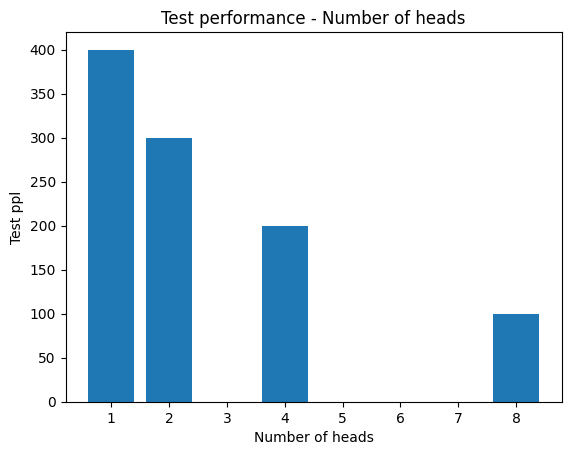

In [ ]:
import matplotlib.pyplot as plt

plt.title("Test performance - Number of heads") # Set graph/figure title
plt.ylabel("Test ppl") # Set y-axis title
plt.xlabel("Number of heads") # Set x-axis title

heads = [1,2,4,8] # assume we try head number of 1, 2, 4, and 8 (i.e., 4 variants)
ppls = [400,300,200,100] # assume we get the corresponding test ppl using each variant head number - you need to get them from your own experiments
plt.bar(heads,ppls) # plot the bar chart

plt.show() # show the bar chart

# More details of .bar() plotting can be found from: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html

In [ ]:
from tabulate import tabulate
heads = [1,2,4,8] # assume we try head number of 1, 2, 4, and 8 (i.e., 4 variants)
ppls = [400,300,200,100] # assume we get the corresponding test ppl using each variant head number - you need to get them from your own experiments
table = [['']+['head '+str(i) for i in heads], ['Test ppl']+ppls]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒══════════╤══════════╤══════════╤══════════╤══════════╕
│          │   head 1 │   head 2 │   head 4 │   head 8 │
╞══════════╪══════════╪══════════╪══════════╪══════════╡
│ Test ppl │      400 │      300 │      200 │      100 │
╘══════════╧══════════╧══════════╧══════════╧══════════╛


## Graph 2 / Table 2 demonstration

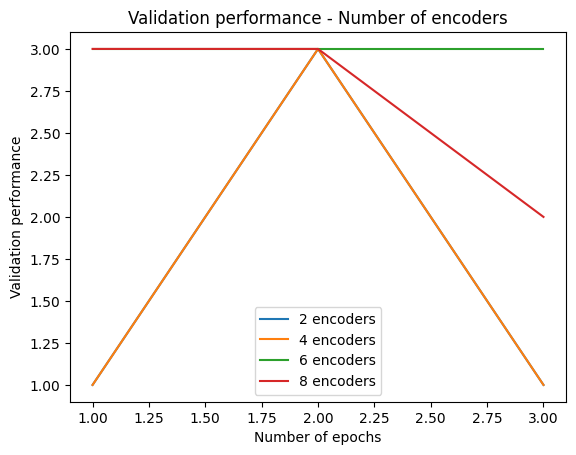

In [ ]:
import matplotlib.pyplot as plt
import random

plt.title("Validation performance - Number of encoders") # Set graph/figure title
plt.ylabel("Validation performance") # Set y-axis title
plt.xlabel("Number of epochs") # Set x-axis title

encoders = [2,4,6,8] # assume we tried 4 variants of encoder layers

for encoder in encoders: # for each encoder variant, we will draw one line graph, showing the validation loss of each epoch
  epochs = [1,2,3] # for each variant, we apply 3 epochs. Thus, we will have epoch 1, 2, 3 (or 0, 1, 2 if you starts with 0)
  val_losses = [random.randint(1, 3), random.randint(1, 3), random.randint(1, 3)] # for each epoch, we recorded the validation loss. Note that here we apply random numbers only for demonstration. However, you need to record your real validation loss if needed.
  plt.plot(epochs,val_losses, label="{0} encoders".format(encoder)) # label each line graph with the encoder number (see the actual plotting in the graph below)

plt.legend(); # this turns on the legends, which shows the label for each line graph. You can comment it out and rerun the code to see the difference
plt.show() # show the final figure

# More details of .plot() plotting can be found from: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html

In [ ]:
from tabulate import tabulate

table=[]
epochs = [1,2,3] # for each variant, we apply 3 epochs. Thus, we will have epoch 1, 2, 3 (or 0, 1, 2 if you starts with 0)

table.append(['']+['epoch '+str(i) for i in encoders]) # append encoder numbers as header

for encoder in encoders: # for each encoder variant, we will have validation loss for each epoch

  val_losses = [random.randint(1, 3), random.randint(1, 3), random.randint(1, 3)] # for each epoch, we recorded the validation loss. Note that here we apply random numbers only for demonstration. However, you need to record your real validation loss if needed.
  table.append(['encoder '+str(encoder)]+val_losses) # append each row data to the table

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═══════════╤═══════════╤═══════════╤═══════════╕
│           │   epoch 2 │   epoch 4 │   epoch 6 │
╞═══════════╪═══════════╪═══════════╪═══════════╡
│ encoder 2 │         2 │         3 │         1 │
├───────────┼───────────┼───────────┼───────────┤
│ encoder 4 │         3 │         1 │         3 │
├───────────┼───────────┼───────────┼───────────┤
│ encoder 6 │         1 │         2 │         3 │
├───────────┼───────────┼───────────┼───────────┤
│ encoder 8 │         2 │         2 │         2 │
╘═══════════╧═══════════╧═══════════╧═══════════╛


## Your solution

Hint: You can easily change the head/encoder number and train the model using the sample code above. For each training, all you need to do is to record the values you need for visualization, e.g., the x and y values if you are using graphs, or the header and row data if you are using tables. Then you can use the graph or table demonstration code to visualize it.

## Sample outputs

Below are several sample outputs for your reference. The code for deriving the corresponding results will be released in the sample solution later. Your visualization can be different based on your own experiments setups and your intention of visualization.

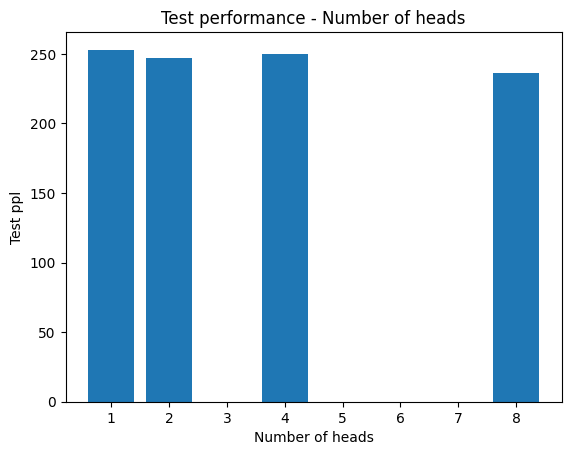

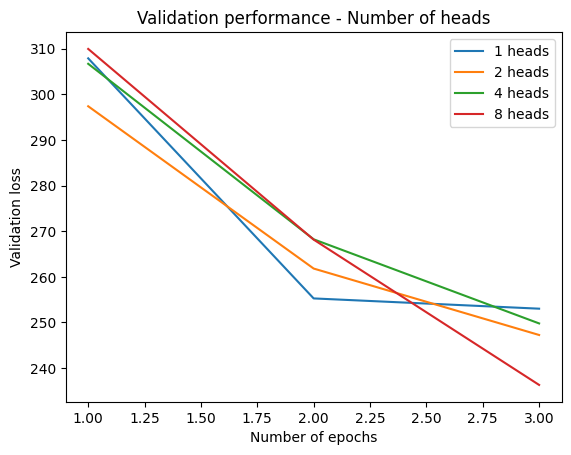

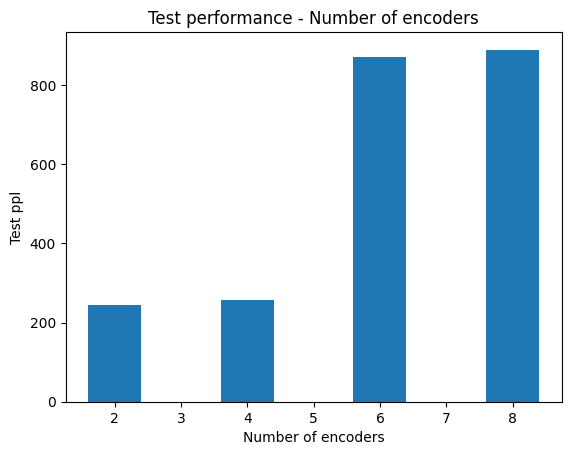

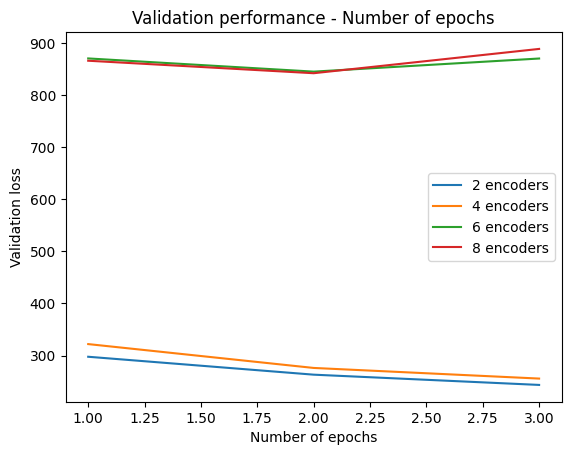